# Map Matching Project - Phase 1
<div style="text-align: center">
<h1 style = "color: red"> Sharif University Of Technology</h1>
<h2 style = "color: green"> DR. Mahdieh Soleymani | DR. MohammadHossein Rohban </h2>
<h3 style = "color: cyan"> Head of Project: AmirHossein Razlighi <h3>
<h3 style = "color: cyan"> Designed By: AmirHossein Razlighi - Hamidreza Yaghoubi - Alireza Heidari - Reza Vahidi Majd - Parham Rezaei<h3>
<h3 style = "color: cyan"> Documents Designed by: Mohammad Moshtaghi Far<h3>
<h4 style = "color: white"> Ask your questions via quera</h4>
<h5> Save your file with format: STUDENT NUMBER_Phase1.ipynb or .zip </h5>
</div>

Setting up the environment

In [ ]:
%pip install pyrosm keplergl haversine pandas numpy

In [24]:
import datetime
import numpy as np
import pandas as pd
import pyrosm
import random
import ssl
import time
from math import radians, sin, cos, sqrt, atan2
import math
from pyproj import Proj
import heapq
from matplotlib import pyplot as plt
import scipy.stats as stats


from keplergl import KeplerGl
from pyrosm import OSM, get_data


In [3]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
import os

Mounted at /content/drive/


In [4]:
%cd /content/drive/MyDrive/AI_proj

/content/drive/MyDrive/AI_proj


In [5]:
# If you are using colab, you need to run this cell
from google.colab import output, files
output.enable_custom_widget_manager()

## Introduction
In this phase of project, you are going to implement a *denoising algorithm*. In many cases, when an application is dealing with _user GPS location_, in many urban areas and the places with tall towers, the GPS signal gets too noisy! This is the reason of why when you open "google maps", you see your current location with a blue circle around it. The radius of this circle shows the accuracy of your location. Sometimes, this radius is around 10m and in other areas, it goes in scale of km, making the GPS location totally unstable and unreliable! This amount of noise makes it impossible to use the data for any kind of analysis. In "ride hailing" applications like Uber, many of functionalities rely on the accuracy of GPS data. E.g. ETA estimation (Estimated time of arrival) is highly dependent on the accuracy of GPS data. In this phase, you are going to implement a denoising algorithm to make the GPS data more reliable. You will use your kowledge of Hidden Markov Models to implement this algorithm.

<div style="text-align: center">
<img src="./Images/blue_dot.jpg" height="500" width="auto" /> </br>
(Sample of GPS data with blue dot)
</div>

# Loading Pasdaran streets dataset

In this section, you will load a dataset that is prepared for you. The dataset contains some GPS locations (nodes) from Pasdaran Streets and also another dataset which contains the "streets" in Pasdaran area. By "street" we mean a pair of nodes, representing two end-points of a street in the map. These datasets are in `Data/` folder with names `pasdaran_streets.csv` and `pasdaran_nodes.csv`.

In [6]:
# Load the data
pasdaran_streets = pd.read_csv('pasdaran_streets.csv')
pasdaran_nodes = pd.read_csv('pasdaran_nodes.csv')

In [7]:
pasdaran_streets.head()

,street_id,u,v,length,oneway,u_lat,u_lon,v_lat,v_lon
0,5003747,423833948,423793584,90.570,no,35.772419,51.465652,35.771748,51.465084
1,17099043,177540293,423832815,296.273,yes,35.771034,51.464462,35.772175,51.461494
2,787945693,4429684144,423832815,62.573,no,35.772636,51.461891,35.772175,51.461494
3,687277053,177540293,423793585,97.898,no,35.771034,51.464462,35.770317,51.463833
4,36333153,9339973930,423793585,296.275,yes,35.771458,51.460865,35.770317,51.463833


In [8]:
pasdaran_nodes.head()

,id,lat,lon
0,423833948,35.772419,51.465652
1,423793584,35.771748,51.465084
2,177536927,35.776230,51.465034
3,177540293,35.771034,51.464462
4,423832815,35.772175,51.461494


In [9]:
map_kepler = KeplerGl(height=600)
map_kepler.add_data(data=pasdaran_nodes, name='Tehran')
map_kepler

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'Tehran': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, …

<div align="center">
  <img src="images/1.png" width="1200" height="600">
</div>

# Creating dataset for trip

As you understood, until now, we loaded 2 datasets, `pasdaran_nodes` and `pasdaran_streets`. Now, we should create a dataset from these, such that we can use it for our trip. Each item in this dataset is called a `ride`. We will explain more as we go on.

First, we should create a **trip** for a driver. For this sake, we should choose 2 random points in our map as the source and destination of the trip. Now, we should find the streets that connect these 2 points. Each street has a length. You should find the shortest path between these 2 points (source and destination) which are in the `pasdaran_streets`. Note that this path should be the **shortest path** meaning that the sum of the lengths of streets should be minimum.

**NOTE**: You cannot use any library for finding the shortest path. You should implement it yourself, from scratch. Feel free to use any algorithm and heuristic that you want. Be creative!

**NOTE**: Be aware of "length of streets" and whether or not they are "one_way"!

In [10]:
# TODO: You should implement this from scratch and you cannot use any library (such as networkx) for finding the shortest path.
def get_edges(graph) :
    edges = {key : {} for key in list(pd.unique(graph[['u', 'v']].values.ravel()))}
    for index, row in graph.iterrows() :
        edges[row['u']][row['v']] = row['length']
        #if row['oneway'] == 'no' :
        edges[row['v']][row['u']] = row['length']
    return edges

def find_shotest_path(start_node, end_node, graph) :
    """
    Find the shortest path between two nodes in a graph.
    :param start_node: The start node
    :param end_node: The end node
    :param graph: The graph
    :return: The shortest path. It is a list of node_ids from start_node to end_node.
    Note that you use all of the data in "pasdaran_streets" dataset appropriately such as "street_length" and "one_way".
    """
    start_node = round(start_node[0], 5), round(start_node[1], 5)
    end_node = round(end_node[0], 5), round(end_node[1], 5)

    start = graph[(round(graph['u_lat'], 5) == start_node[0]) & (round(graph['u_lon'], 5) == start_node[1])][['u']].values.tolist()
    if len(start) == 0 :
        start = graph[(round(graph['v_lat'], 5) == start_node[0]) & (round(graph['v_lon'], 5) == start_node[1])][['v']].values.tolist()

    end = graph[(round(graph['v_lat'], 5) == end_node[0]) & (round(graph['v_lon'], 5) == end_node[1])][['v']].values.tolist()
    if len(end) == 0 :
        end = graph[(round(graph['u_lat'], 5) == end_node[0]) & (round(graph['u_lon'], 5) == end_node[1])][['u']].values.tolist()

    start = start[0][0]
    end = end[0][0]

    edges = get_edges(graph)
    shortest_path = []
    fringe = {start : 0}
    parents = {node: None for node in edges.keys()}
    visited_nodes = set()

    while len(fringe.keys()) != 0 :
        node = min(fringe, key=fringe.get)

        if node == end :
            break

        visited_nodes.add(node)

        neighbors = edges[node]
        for neighbor in neighbors.keys() :
            f = fringe[node] + neighbors[neighbor]
            if neighbor not in visited_nodes or (neighbor in fringe.keys() and f < fringe[neighbor]) :
                fringe[neighbor] = f
                parents[neighbor] = node
                visited_nodes.add(neighbor)
        del fringe[node]

    node = end
    while node != None :
        shortest_path.append(node)
        node = parents[node]

    shortest_path.reverse()
    return shortest_path

You should **upload** this cell (`find_shortest_path` function) as a .py file to quera. Your code will be verified if it is actually finding the shortest path and only if it's correct, you will get the grades of this section. Be sure that you put the approriate `import ...` statements at the first of your `.py` file. Remember, you **can not** use any library that does the "shortest path" for you. (like networkx) You should implement it yourself.

**Note**: You can add other functions and codes to above cell, but you code should have the `find_shortest_path` function with exactly same signature that we have provided. Your code will be tested with calling this function. So, using other functions is not a problem, but keep in mind that the main entry for your code when we test it is the `find_shortest_path` function. Nothing else!

In [11]:
# Create a trip: Choose 2 random points as start and end points and find the shortest path between them.
# A trip is a list of node_ids from start_node to end_node.

# TODO: Implement and print out a sample trip
trip = find_shotest_path((35.7751197814941, 51.4479751586914), (35.7798652648925, 51.4644432067871), pasdaran_streets)
print(trip)

[423816012, 4316456851, 423816018, 423816019, 4316456858, 4695998355, 4551688565, 423815693, 423815694, 4698536184, 423815692, 423815695, 423832812, 423832813, 4698544220, 4698544218, 4695975713, 423793661, 4695969098, 806589258, 1707151175, 423793624, 6096557785, 10922701617, 10922701619, 10922701618, 6096557786, 6434310435, 423833953, 2193982049, 2193982051, 4698562498, 2106802321, 1707151181, 4696632867, 4696632868, 4696632866, 1707151183, 4696632871, 4696627041, 423832940, 4696627040, 4696627039]


Visualize the sampled trip (in the previous cell) on the map. Use `kepler` library for this purpose. Notice that you use keplers "timestep" attributes to create a timeline, so you can see the trip's process from _start\_node_ to _end\_node_. (You can see an output sample in the next cell)

In [12]:
df1 = pasdaran_nodes[pasdaran_nodes['id'].isin(trip)]
df1 = df1.sort_values(by=['id'], key=lambda x: x.map({v: i for i, v in enumerate(trip)}))


df1['timestep'] = [i for i in range(len(trip))]

map1 = KeplerGl(height=750)
map1.add_data(data=df1, name='Tehran')
map1

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'Tehran': {'index': [649, 648, 154, 157, 647, 646, 645, 140, 139, 138, 137, 459, 444, 460, 461,…

<div align="center">
  <img src="images/2.png" width="1200" height="600">
</div>

Now, we are going to get the points in the middle of the streets. Before, we only had the intersections of the streets(start and end nodes of a section). But we know in real life, we get gps locations also in between and not necessarily in the intersections. So, we should add these points to our data. We call every entity of this type as `Ride`. A ride is defined by 3 parameters:
1. `ride_speed`: The speed of the ride which driver is driving with. We assume that the driver is driving with a constant speed.
2. `driver_gps_time`: The time interval that the driver sends his/her gps location to the server. (e.g. every 5 seconds)
3. `trip`: The specific trip that the driver is driving in. (we created this in the previous cells)

Now, you should define a function that gets these parameters and returns the locations (lat/longs) in the ride regarding the given parameters.

In [16]:
def get_lengths(trip) :
    distances = []
    for i in range(len(trip) - 1) :
        u, v = pasdaran_nodes[pasdaran_nodes['id'] == trip[i]][['lat', 'lon']].values.tolist(), pasdaran_nodes[pasdaran_nodes['id'] == trip[i+1]][['lat', 'lon']].values.tolist()
        distance = pasdaran_streets[(pasdaran_streets['u'] == trip[i]) & (pasdaran_streets['v'] == trip[i+1]) | (pasdaran_streets['v'] == trip[i]) & (pasdaran_streets['u'] == trip[i+1])][['length']].values[0]
        distances.append([(u[0][0], u[0][1]), (v[0][0], v[0][1]), distance])
    return distances

def get_lat_lon(u, v, distance, length) :
    u_lat, u_lon = u[0][0], u[0][1]
    v_lat, v_lon = v[0][0], v[0][1]

    weight = distance / length

    lat = weight * u_lat + (1 - weight) * v_lat
    lon = weight * u_lon + (1 - weight) * v_lon
    return lat[0], lon[0]

def generate_intermediate_point(lat_a, lon_a, lat_b, lon_b, portion):
    lat_a_rad = math.radians(lat_a)
    lon_a_rad = math.radians(lon_a)
    lat_b_rad = math.radians(lat_b)
    lon_b_rad = math.radians(lon_b)

    # meter
    earth_radius = 6371000

    delta_sigma = 2 * math.asin(
        math.sqrt(
            math.sin((lat_b_rad - lat_a_rad) / 2) ** 2 +
            math.cos(lat_a_rad) * math.cos(lat_b_rad) * math.sin((lon_b_rad - lon_a_rad) / 2) ** 2
        )
    )
    total_distance = earth_radius * delta_sigma

    intermediate_distance = total_distance * portion

    bearing = math.atan2(
        math.sin(lon_b_rad - lon_a_rad) * math.cos(lat_b_rad),
        math.cos(lat_a_rad) * math.sin(lat_b_rad) - math.sin(lat_a_rad) * math.cos(lat_b_rad) * math.cos(lon_b_rad - lon_a_rad)
    )

    intermediate_lat = math.asin(math.sin(lat_a_rad) * math.cos(intermediate_distance / earth_radius) +
                                 math.cos(lat_a_rad) * math.sin(intermediate_distance / earth_radius) * math.cos(bearing))
    intermediate_lon = lon_a_rad + math.atan2(
        math.sin(bearing) * math.sin(intermediate_distance / earth_radius) * math.cos(lat_a_rad),
        math.cos(intermediate_distance / earth_radius) - math.sin(lat_a_rad) * math.sin(intermediate_lat)
    )

    intermediate_lat_deg = math.degrees(intermediate_lat)
    intermediate_lon_deg = math.degrees(intermediate_lon)

    return intermediate_lat_deg, intermediate_lon_deg


def get_current_node(distance, lengths, index, trip) :
    for i in range(index, len(lengths)) :
        u_lat, u_lon = lengths[i][0][0], lengths[i][0][1]
        v_lat, v_lon = lengths[i][1][0], lengths[i][1][1]
        length = lengths[i][2]

        if distance <= length :
            lat, lon = generate_intermediate_point(u_lat, u_lon, v_lat, v_lon, distance / length)
            return lat, lon, length - distance, i
        else :
            distance -= length
    return lengths[len(lengths) - 1][1][0], lengths[len(lengths) - 1][1][1], 0, len(lengths) - 1

def visualize_a_ride(ride_speed, ride_gps_time, trip) :
    # x = vt
    lengths = get_lengths(trip)
    ride = []

    i = 0
    u = trip[i]
    v = trip[i+1]
    distance = ride_speed * ride_gps_time

    ride.append(list(lengths[0][0]))

    while i < len(lengths) - 1 :
        lat, lon, length, i = get_current_node(distance, lengths, i, trip)
        lengths.insert(i+1, [(lat, lon), lengths[i][1], length])
        i += 1
        ride.append([lat, lon])
    return ride

See a sample ride, printed out.

In [17]:
ride = visualize_a_ride(60, 1, trip)
ride

<ipython-input-16-ba096c546c8c>:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intermediate_lat = math.asin(math.sin(lat_a_rad) * math.cos(intermediate_distance / earth_radius) +
<ipython-input-16-ba096c546c8c>:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  math.cos(lat_a_rad) * math.sin(intermediate_distance / earth_radius) * math.cos(bearing))
<ipython-input-16-ba096c546c8c>:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  math.sin(bearing) * math.sin(inte

[[35.77511978149414, 51.447975158691406],
 [35.77562687681527, 51.448202477143326],
 [35.776134751337054, 51.44842703868589],
 [35.776644415291905, 51.448645466747905],
 [35.777148980419554, 51.44888116460721],
 [35.77765410690363, 51.449115038877814],
 [35.778150303268646, 51.44935325126417],
 [35.77821741592872, 51.450013197010676],
 [35.77828425072117, 51.45067318385095],
 [35.778349454025175, 51.451333414966804],
 [35.778420903306206, 51.451992618979794],
 [35.778497937147634, 51.45265091602301],
 [35.778552306259414, 51.453312597541355],
 [35.77859550058828, 51.453973352728845],
 [35.778435539939615, 51.454608563186675],
 [35.778265060883754, 51.455239376085466],
 [35.778100792399314, 51.45587290295374],
 [35.77793443218248, 51.456505611514416],
 [35.77776503374557, 51.457137079214924],
 [35.7775851263254, 51.45776403567846],
 [35.77738730928046, 51.45838281337384],
 [35.777186773992995, 51.459000263686576],
 [35.7769976906784, 51.45961061555368],
 [35.77745534268614, 51.459757645

Visualize the sample ride on the map using `kepler` library. You should define an animation based on the order of the points in the ride, so you can play the animation in the visualization and see the ride!

In [18]:
df2 = {
    'lat': [ride[i][0] for i in range(len(ride))],
    'lon': [ride[i][1] for i in range(len(ride))],
    'timestamp': [i for i in range(len(ride))]
}
df2 = pd.DataFrame(df2)

map2 = KeplerGl(height=750)
map2.add_data(data=df2, name='data')
map2

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'data': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21…

<div align="center">
  <img src="images/3.png" width="1200" height="600">
</div>

Now, to complete our dataset, we need to put some random noise on the gps locations. For this sake, we easily add some random noise to the lat/longs of a created `ride`. You should define a function that gets a `ride` and adds some random noise to the lat/longs of the ride. Your function should take in 2 parameters: _ride_ and _gps\_noise\_radius_ which is the radius of the circle that you want to add noise to the gps locations. (e.g. 10 meters). The gps noise in assumed to be a normal distribution. So, assume `standard deviation` of the noise to be `gps_noise_radius`.

In [19]:
# put a random noise on each (lat, lon) location to simulate the GPS noise (suppoes GPS radius is 3 - 8 meters)
def add_gps_noise(ride, gps_noise_radius):
    lat_noise = list(np.random.normal(0, gps_noise_radius, len(ride)))
    lon_noise = list(np.random.normal(0, gps_noise_radius, len(ride)))

    lat = [ride[i][0] for i in range(len(ride))]
    lon = [ride[i][1] for i in range(len(ride))]

    noisy_lat = []
    noisy_lon = []
    for i in range(len(lat)) :
        noisy_lat.append(lat[i] + (lat_noise[i] / 111320))
        noisy_lon.append(lon[i] + (lon_noise[i] / (111320 * math.cos(math.radians(lat[i])))))

    return [[lat, lon] for (lat, lon) in zip(noisy_lat, noisy_lon)]


noisy_ride = add_gps_noise(ride, 5)
noisy_ride

[[35.775152873690494, 51.44799626936076],
 [35.77558358440374, 51.448008523234165],
 [35.77618270286632, 51.4484432385927],
 [35.77665008500917, 51.448648860278006],
 [35.77711378156916, 51.44882639730732],
 [35.777650044573136, 51.44906798604769],
 [35.7781684747808, 51.4493476679354],
 [35.77824479805588, 51.450034572118795],
 [35.778321708106105, 51.45063207284447],
 [35.77837645219671, 51.45131662555119],
 [35.77838896602104, 51.4519350315725],
 [35.77853302812279, 51.45254384546401],
 [35.778501567177315, 51.45336891487549],
 [35.77864062535089, 51.45399223654482],
 [35.77840905831393, 51.45460981632993],
 [35.778271948534346, 51.455259644788946],
 [35.77811229395416, 51.45590297995062],
 [35.77802658340524, 51.45643097894064],
 [35.777709855255345, 51.457117673860054],
 [35.77763497892794, 51.45761606589028],
 [35.77741181847348, 51.45849095582153],
 [35.77724141591094, 51.459079160465855],
 [35.77701320325063, 51.45962257545556],
 [35.77744840340649, 51.459801442977984],
 [35.77

In [20]:
df3 = {
    'lat': [noisy_ride[i][0] for i in range(len(noisy_ride))],
    'lon': [noisy_ride[i][1] for i in range(len(noisy_ride))],
    'timestamp': [i for i in range(len(noisy_ride))]
}
df3 = pd.DataFrame(df3)

map3 = KeplerGl(height=750)
map3.add_data(data=df3, name='data')
map3

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'data': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21…

<div align="center">
  <img src="images/4.png" width="1200" height="600">
</div>

### Different noise models
Experiment adding noise to rides using different models (PDFs) of noise. For example, you can use a uniform distribution for noise. Or you can use a normal distribution for noise. Or you can use a mixture of different distributions. You can also use a distribution that is dependent on the speed of the ride.
1. Visualize each noise model (PDF) on a plot. (You can use `matplotlib` library for this purpose)
2. Visualize the rides with different noise models on the map. (You can use `kepler` library for this purpose)
3. Compare the results of different noise models. Which one is more descriptive of the real world? Why?
4. Choose one model that you find appropriate for training your HMM on it. We will use that model for the rest of the project.

In [23]:
def add_noise(lat, lon, lat_noise, lon_noise) :
    noisy_lat = []
    noisy_lon = []
    for i in range(len(lat)) :
        noisy_lat.append(lat[i] + (lat_noise[i] / 111320))
        noisy_lon.append(lon[i] + (lon_noise[i] / (111320 * math.cos(math.radians(lat[i])))))

    return [[lat, lon] for (lat, lon) in zip(noisy_lat, noisy_lon)]

def plot_noise(lat_noise, lon_noise) :
    plt.hist(lat_noise, bins=20, edgecolor='black')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('lat noise')
    plt.grid(True)
    plt.show()

    plt.hist(lon_noise, bins=20, edgecolor='black')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('lon noise')
    plt.grid(True)
    plt.show()

def convert_to_df(ride) :
    df = {
    'lat': [ride[i][0] for i in range(len(ride))],
    'lon': [ride[i][1] for i in range(len(ride))],
    'timestamp': [i for i in range(len(ride))]}
    df = pd.DataFrame(df)
    return df

def visualize_kepler(noisy_ride) :
    df = convert_to_df(noisy_ride)
    map = KeplerGl(height=750)
    map.add_data(data=df, name='data')
    return map

In [25]:
lat = [ride[i][0] for i in range(len(ride))]
lon = [ride[i][1] for i in range(len(ride))]
gps_noise_radius = 7

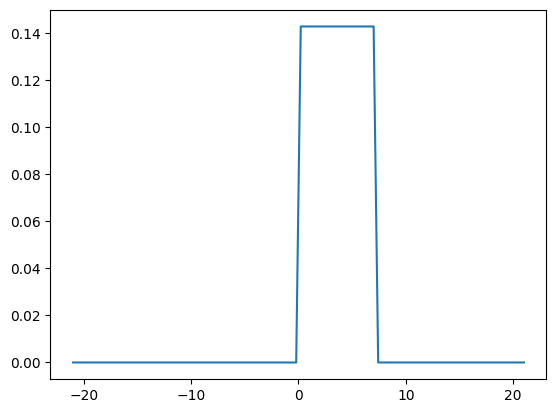

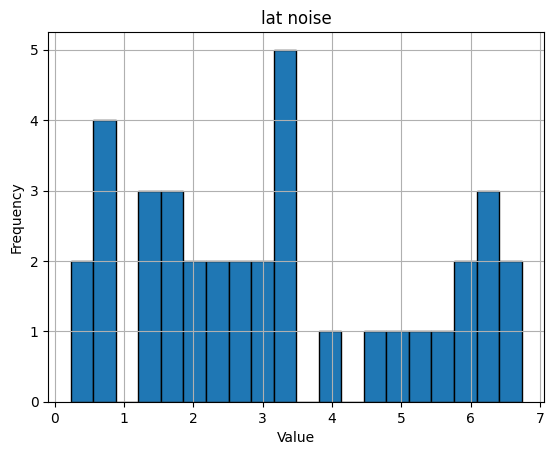

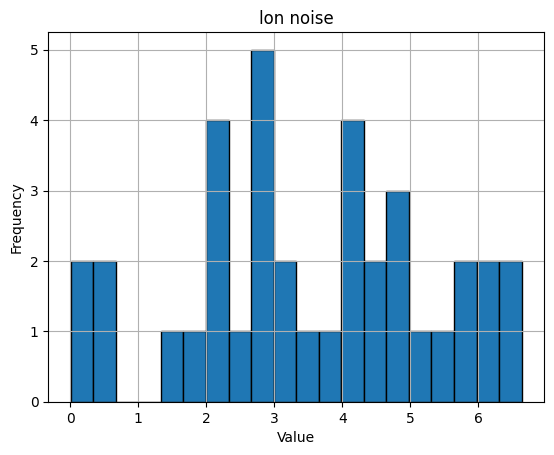

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'data': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21…

In [26]:
# uniform
mu = 0
sigma = gps_noise_radius
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.uniform.pdf(x, mu, sigma))
plt.show()


lat_noise = list(np.random.uniform(0, gps_noise_radius, len(ride)))
lon_noise = list(np.random.uniform(0, gps_noise_radius, len(ride)))
uniform_ride_r5 = add_noise(lat, lon, lat_noise, lon_noise)
plot_noise(lat_noise, lon_noise)
visualize_kepler(uniform_ride_r5)

<div align="center">
  <img src="images/5.png" width="1200" height="600">
</div>

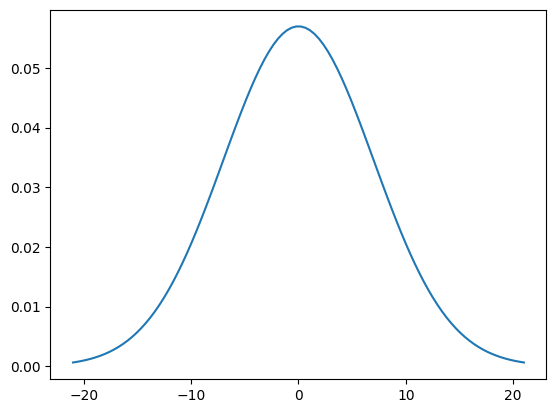

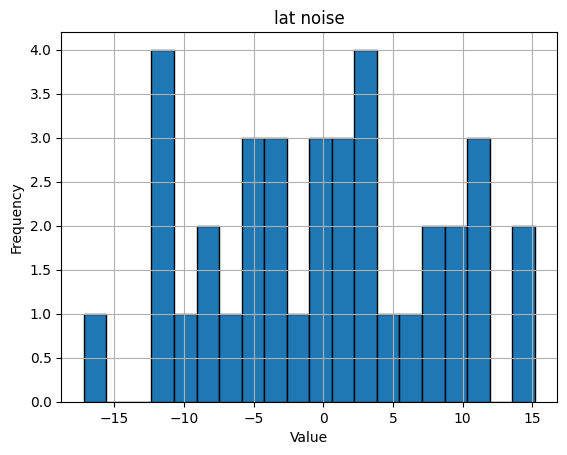

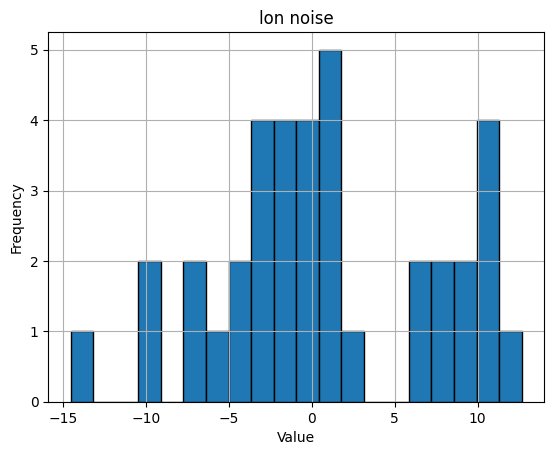

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'data': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21…

In [27]:
# normal
mu = 0
sigma = gps_noise_radius
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.show()


lat_noise = list(np.random.normal(0, gps_noise_radius, len(ride)))
lon_noise = list(np.random.normal(0, gps_noise_radius, len(ride)))
normal_ride_r5 = add_noise(lat, lon, lat_noise, lon_noise)
plot_noise(lat_noise, lon_noise)
visualize_kepler(normal_ride_r5)

<div align="center">
  <img src="images/6.png" width="1200" height="600">
</div>

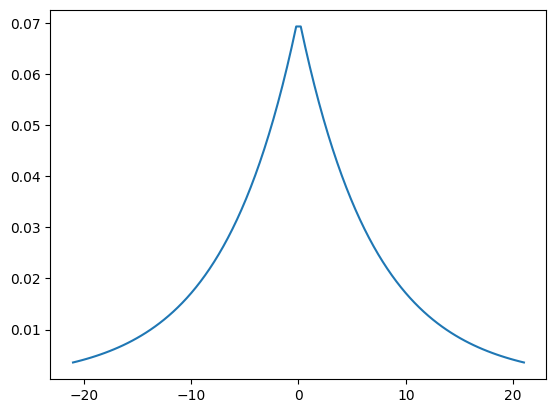

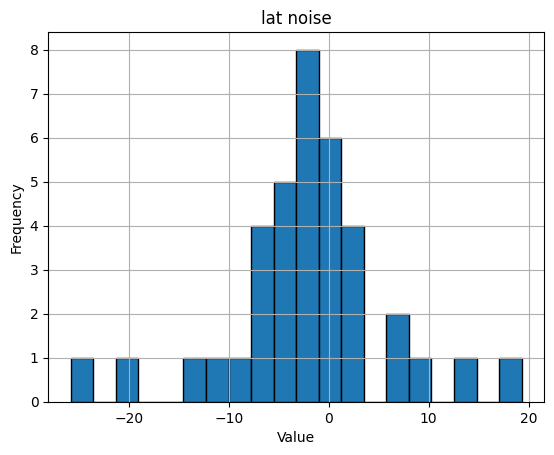

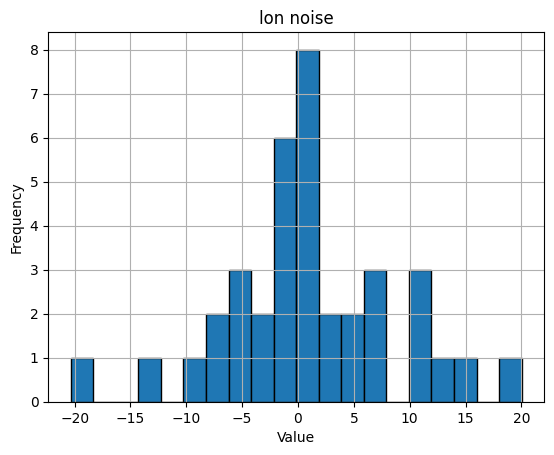

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'data': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21…

In [28]:
# laplace
mu = 0
sigma = gps_noise_radius
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.laplace.pdf(x, mu, sigma))
plt.show()

lat_noise = list(np.random.laplace(0, gps_noise_radius, len(ride)))
lon_noise = list(np.random.laplace(0, gps_noise_radius, len(ride)))
laplace_ride_r5 = add_noise(lat, lon, lat_noise, lon_noise)
plot_noise(lat_noise, lon_noise)
visualize_kepler(laplace_ride_r5)

<div align="center">
  <img src="images/7.png" width="1200" height="600">
</div>

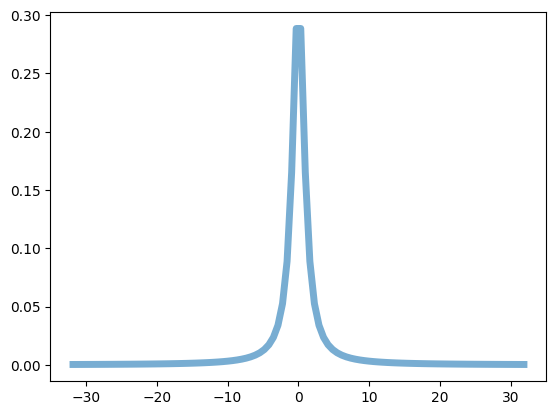

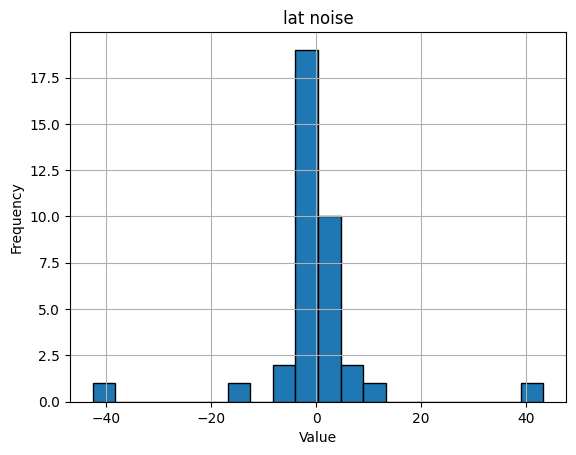

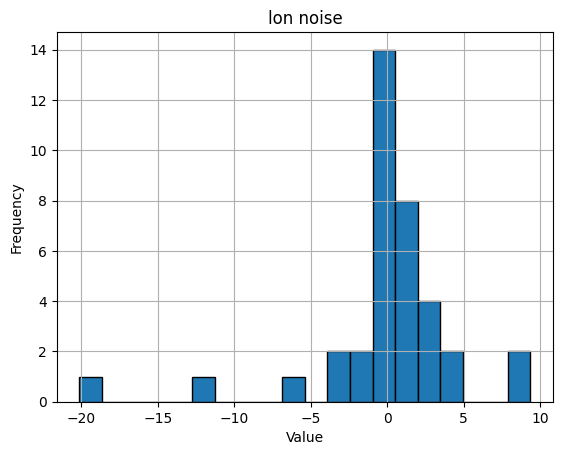

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'data': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21…

In [29]:
# cauchy
x = np.linspace(stats.cauchy.ppf(0.01), stats.cauchy.ppf(0.99), 100)
plt.plot(x, stats.cauchy.pdf(x), lw=5, alpha=0.6)
plt.show()

lat_noise = list(np.random.standard_cauchy(len(ride)))
lon_noise = list(np.random.standard_cauchy(len(ride)))
cauchy_ride = add_noise(lat, lon, lat_noise, lon_noise)
plot_noise(lat_noise, lon_noise)
visualize_kepler(cauchy_ride)

<div align="center">
  <img src="images/8.png" width="1200" height="600">
</div>

**Explanation of my noise model:**

Above, I experimented with various bowl-shaped distributions (excluding the uniform distribution). Based on the following reasons, I believe that modeling the GPS noise using these distributions can yield better results:

1.owl-shaped distributions exhibit symmetry around their central point. This symmetry implies that positive and negative deviations from the central point are equally likely, making it easier to analyze the data or model.

2.Bowl-shaped distributions typically possess a well-defined central tendency, such as a mean or median. This central point provides a measure of the typical or average behavior, which aids in understanding the data as a whole.

3.The shape of bowl-shaped distributions reflects a balance between positive and negative values. This balance suggests that extreme values or outliers are less probable, enhancing the stability and predictability of the distribution.

Upon comparing the maps and histograms, the following conclusions can be drawn:

Normal Distribution:

- The normal distribution demonstrates symmetry around its mean, implying that positive and negative deviations from the mean are equally likely. This assumption is reasonable when expecting no bias or systematic shift in any particular direction for the GPS noise.

- The normal distribution accommodates a wide range of variability, with tails that extend to infinity. Hence, it is suitable for representing a broad range of GPS noise magnitudes.

- Central Limit Theorem: As mentioned earlier, the normal distribution often serves as a good approximation when the GPS noise arises from the aggregation of independent, identically distributed random variables.

Uniform Distribution:

- The uniform distribution is symmetric and assumes that all values within a certain range are equally likely. However, if the GPS noise is subject to biases or other systematic errors, the uniform distribution may not be suitable.

- The uniform distribution assumes a constant and fixed variability. If the GPS noise exhibits varying levels of variability, with certain measurements more likely than others, the uniform distribution may fail to capture this characteristic adequately.

Cauchy Distribution:

- The Cauchy distribution possesses heavy tails, allowing for extreme outliers. If the GPS noise contains rare extreme values that occur more frequently than expected from a normal distribution, the Cauchy distribution might be a more appropriate choice.

- Sensitivity to Outliers: While the Cauchy distribution accommodates extreme values, it is highly sensitive to outliers. A single outlier can significantly impact its shape and properties, which might not align with the characteristics of GPS noise.

Laplace Distribution:

- The Laplace distribution is symmetric, similar to the normal distribution, but with sharper peaks and thicker tails. If the GPS noise exhibits a slightly higher probability of small deviations from the mean, the Laplace distribution can be an alternative to the normal distribution.

- Sparsity and Bimodality: The Laplace distribution can handle sparsity and bimodality, indicating the presence of distinct groups of values or intervals with higher or lower probability density. If the GPS noise exhibits such characteristics, the Laplace distribution may be worth considering.

In conclusion, using the normal distribution seems reasonable due to its natural representation, low probabilities for extreme noises, and the ability to capture shifts in points beyond the minimum level.

Visualize a sample `ride` and its corresponding `noisy_ride` (using your selected noise model) on the map.

In [30]:
normal_df = convert_to_df(normal_ride_r5)
map4 = KeplerGl(height=750)
map4.add_data(data=df2, name='ride')
map4.add_data(data=normal_df, name='noisy ride')
map4

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'ride': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21…

<div align="center">
  <img src="images/9.png" width="1200" height="600">
</div>

Now, we create our dataset, We create 20 noisy_rides for each trip.

In [31]:
noisy_rides_list = []
lat = [ride[i][0] for i in range(len(ride))]
lon = [ride[i][1] for i in range(len(ride))]

for _ in range(20) :
    lat_noise = list(np.random.normal(0, gps_noise_radius, len(ride)))
    lon_noise = list(np.random.normal(0, gps_noise_radius, len(ride)))
    noisy_rides_list.append(add_noise(lat, lon, lat_noise, lon_noise))
noisy_rides_list

[[[35.77526875587595, 51.448062781288726],
  [35.77555067210806, 51.44817802523146],
  [35.776184688616006, 51.448522383844704],
  [35.77673740404307, 51.448663776262734],
  [35.777221523145755, 51.44893544967227],
  [35.777719078628316, 51.44923583654689],
  [35.77821653363855, 51.449486272808905],
  [35.77830739222002, 51.44999590964996],
  [35.77827440628166, 51.450707375511094],
  [35.778297821989, 51.45127540378473],
  [35.77835560453834, 51.45209004011258],
  [35.77851036698125, 51.4525425714633],
  [35.77864493220576, 51.45334867328384],
  [35.778684896612226, 51.453931537604774],
  [35.77833442739168, 51.45450501638759],
  [35.77825397588518, 51.45526310613717],
  [35.77799652095278, 51.4558206145822],
  [35.77786091730652, 51.45647723328415],
  [35.77779731503306, 51.45716004003507],
  [35.77756835441406, 51.457682786909984],
  [35.77733123453821, 51.45851395895617],
  [35.7772547949441, 51.45895912680476],
  [35.77699067238197, 51.45957502622617],
  [35.77743138341018, 51.459

# HMM

In this section, we want to use the dataset that we created in the previous section to train an HMM model. We want to use HMM models to  **denoise** the gps locations of the rides. We assume that the gps locations of the rides are noisy and we want to denoise them using HMM models. The observations in each _timestamp_ are the observed noisy points in the dataset.

You should implement a class (or function) named HMM which gets the noisy observations and the `streets` of the map (of course, this is not noisy. we saw that as `pasdaran_streets` in the previous section). You should calculate the transition matrix and emission matrix of the HMM model. You should also implement the `viterbi` algorithm to find the most probable sequence of hidden states (which are the points in the streets) given the noisy observations. Finally, your implementation should be capable of returning the denoised gps locations of the rides. Note that how you define your features, and your states. Be creative!

In [32]:
def calculate_distance(u_lat, u_lon, v_lat, v_lon):
    # Convert coordinates from degrees to radians
    u_lat_rad = radians(u_lat)
    u_lon_rad = radians(u_lon)
    v_lat_rad = radians(v_lat)
    v_lon_rad = radians(v_lon)

    # Radius of the Earth in meters
    R = 6371000

    # Haversine formula
    delta_lat = v_lat_rad - u_lat_rad
    delta_lon = v_lon_rad - u_lon_rad
    a = sin(delta_lat / 2)**2 + cos(u_lat_rad) * cos(v_lat_rad) * sin(delta_lon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c

    return distance

In [33]:
def project_point_on_street(u_lat, u_lon, v_lat, v_lon, e_lat, e_lon):
    # Define the projection to be used (e.g., Mercator)
    projection = Proj(proj='merc', ellps='WGS84')

    # Project the points to a Cartesian coordinate system
    u_x, u_y = projection(u_lon, u_lat)
    v_x, v_y = projection(v_lon, v_lat)
    e_x, e_y = projection(e_lon, e_lat)

    # Calculate the dot product between the vectors (u -> v) and (u -> e)
    ux = v_x - u_x
    uy = v_y - u_y
    ex = e_x - u_x
    ey = e_y - u_y

    dot_product = ux * ex + uy * ey

    # Calculate the squared length of the vector (u -> v)
    uv_length_squared = ux**2 + uy**2

    # Calculate the projection factor
    projection_factor = dot_product / uv_length_squared

    if projection_factor < 0:
        # The projection falls before the starting point (u)
        projected_x = u_x
        projected_y = u_y
    elif projection_factor > 1:
        # The projection falls after the ending point (v)
        projected_x = v_x
        projected_y = v_y
    else:
        # The projection falls on the line segment between u and v
        projected_x = u_x + projection_factor * ux
        projected_y = u_y + projection_factor * uy

    # Convert the projected point back to latitude-longitude coordinates
    projected_lon, projected_lat = projection(projected_x, projected_y, inverse=True)

    return projected_lat, projected_lon

In [34]:
def get_streets_near_evidence(noisy_ride, pasdaran_streets) :
    streets = [{} for _ in range(len(noisy_ride))]
    key = 0
    for i in range(len(noisy_ride)) :
        distance_based_streets = []
        for index, row in pasdaran_streets.iterrows() :
            proj_lat, proj_lon = project_point_on_street(row['u_lat'], row['u_lon'], row['v_lat'], row['v_lon'], noisy_ride[i][0], noisy_ride[i][1])
            distance = calculate_distance(noisy_ride[i][0], noisy_ride[i][1], proj_lat, proj_lon)
            heapq.heappush(distance_based_streets, (distance, [key, [proj_lat, proj_lon], 0, 0]))
            key += 1
        j = 4
        while len(distance_based_streets) > 0 and j > 0 :
            l = heapq.heappop(distance_based_streets)[1]
            streets[i][l[0]] = l[1:]
            j -= 1

    return streets

In [35]:
def transition_probability(current, current_evidence, next, next_evidence, beta) :
    current_lat, current_lon, current_evidence_lat, currenct_evidence_lon = current[0], current[1], current_evidence[0], current_evidence[1]
    next_lat, next_lon, next_evidence_lat, next_evidence_lon = next[0], next[1], next_evidence[0], next_evidence[1]

    evidence_distance = calculate_distance(current_evidence_lat, currenct_evidence_lon, next_evidence_lat, next_evidence_lon)
    state_distance = calculate_distance(current_lat, current_lon, next_lat, next_lon)

    return math.exp(-abs(state_distance - evidence_distance) / beta) / beta + 0.0000001

In [36]:
def emission_probability(state, evidence, std) :
    lat, lon = state[0], state[1]
    evidence_lat, evidence_lon = evidence[0], evidence[1]

    distance = calculate_distance(lat, lon, evidence_lat, evidence_lon)
    return math.exp(-0.5 * (distance / std) ** 2) / (math.sqrt(2 * math.pi) * std) + 0.0000001

In [37]:
def get_normal_std(noisy_rides, ride) :
    ride_distances = []
    for noisy_ride in noisy_rides :
        for i in range(len(noisy_ride)) :
            r1, r2 = 0, 0
            if i == len(noisy_ride) - 1 :
                r1, r2 = ride[i-1], ride[i]
            else :
                r1, r2 = ride[i], ride[i+1]
            nr = noisy_ride[i]
            proj_lat, proj_lon = project_point_on_street(r1[0], r1[1], r2[0], r2[1], nr[0], nr[1])
            ride_distances.append(calculate_distance(proj_lat, proj_lon, nr[0], nr[1]))

    mean = sum(ride_distances) / len(ride_distances)
    variance = sum((x - mean)**2 for x in ride_distances) / len(ride_distances)
    std = math.sqrt(variance)
    return std

def get_beta(noisy_rides, ride) :
    diff_list = []
    for noisy_ride in noisy_rides :
        for i in range(len(ride) - 2) :
            r1, r2, r3 = ride[i], ride[i+1], ride[i+2]
            nr1, nr2 = noisy_ride[i], noisy_ride[i+1]
            proj_lat1, proj_lon1 = project_point_on_street(r1[0], r1[1], r2[0], r2[1], nr1[0], nr1[1])
            proj_lat2, proj_lon2 = project_point_on_street(r2[0], r2[1], r3[0], r3[1], nr2[0], nr2[1])
            diff_list.append(abs(calculate_distance(nr1[0], nr1[1], nr2[0], nr2[1]) - calculate_distance(proj_lat1, proj_lon1, proj_lat2, proj_lon2)))
    return sum(diff_list) / len(diff_list)

In [38]:
def get_transitions(states, noisy_ride, beta) :
    transitions = [{} for _ in range(len(noisy_ride))]

    for i in range(1, len(noisy_ride)) :
        for prev_key, prev_value in states[i-1].items() :
            prob_list = []
            for curr_key, curr_value in states[i].items() :
                T = transition_probability(prev_value[0], noisy_ride[i-1], curr_value[0], noisy_ride[i], beta)
                prob_list.append(T)

                if prev_key not in transitions[i].keys() :
                    transitions[i][prev_key] = {}

                transitions[i][prev_key][curr_key] = T
            total = sum(prob_list)
            for key, value in transitions[i][prev_key].items() :
                transitions[i][prev_key][key] /= total

    return transitions

In [39]:
def get_emissions(states, noisy_ride, std) :
    emissions = [{} for _ in range(len(noisy_ride))]

    for i in range(0, len(noisy_ride)) :
        prob_list = []
        for key, value in states[i].items() :
            E = emission_probability(value[0], noisy_ride[i], std)
            prob_list.append(E)
            emissions[i][key] = E
        total = sum(prob_list)
        for key, value in emissions[i].items() :
            emissions[i][key] /= total

    return emissions

In [40]:
# Viterbi algorithm for finding the most likely sequence of states
def viterbi(noisy_ride, ride, states, std, beta) :
    if len(states) == 0 :
        return -1

    transitions = get_transitions(states, noisy_ride, beta)
    emissions = get_emissions(states, noisy_ride, std)

    for key, value in states[0].items() :
        states[0][key][1] = emissions[0][key]
        states[0][key][2] = key

    for i in range(1, len(noisy_ride)) :
        for curr_key, curr_value in states[i].items() :
            for prev_key, prev_value in states[i-1].items() :
                m = states[i-1][prev_key][1] * emissions[i][curr_key] * transitions[i][prev_key][curr_key]
                if states[i][curr_key][1] <= m :
                    states[i][curr_key][1] = m
                    states[i][curr_key][2] = prev_key

    sequence = []

    max_M = -1
    current_id = 0
    for key, value in states[-1].items() :
        if value[1] > max_M :
            current_id = key
            max_M = value[1]

    for i in reversed(range(len(noisy_ride))) :
        sequence.insert(0, states[i][current_id][0])
        current_id = states[i][current_id][2]
    return sequence

In [41]:
std = get_normal_std(noisy_rides_list, ride)
beta = get_beta(noisy_rides_list, ride)

In [42]:
states = get_streets_near_evidence(normal_ride_r5, pasdaran_streets)
denoised_ride = viterbi(normal_ride_r5, ride, states, std, beta)

Visualize a sample denoised _ride_ using your HMM model. Put `original_points` and `denoised_points` on the map. Use different colors for each of them to make them distinct from eachother. You should use `kepler` library for this purpose.

In [43]:
def convert_to_df(data) :
    df = {
          'lat': [data[i][0] for i in range(len(data))],
          'lon': [data[i][1] for i in range(len(data))]
      }
      return pd.DataFrame(df)

In [44]:
denoised_df = convert_to_df(denoised_ride)

ride_df = convert_to_df(ride)
noisy_df = convert_to_df(normal_ride_r5)

map5 = KeplerGl(height=750)
map5.add_data(data=ride_df, name='ride')
map5.add_data(data=denoised_df, name='denoised ride')
map5

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'ride': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21…

<div align="center">
  <img src="images/10.png" width="1200" height="600">
</div>

# Testing your model

In this section, you should test your model. You could use your dataset (which you generated, step-by-step) until now, to implement, debug and train your model. Now, you should load `test_dataset` that we provided to you as `noisy_test_dataset.csv` and `original_test_dataset.csv`. Run your model on `noisy_test_dataset` and use `original_test_dataset` to evaluate how good you did. run your model on `noisy_test_dataset` to denoise the points. You should put the denoised points in a csv file named `denoised_test_dataset.csv` and submit it with your notebook. Also, You should report the **Mean haversine distance (MHD)** as the measaure of the loss of your model. Go through each trip in the `noisy_test_dataset` and calculate the MHD for each trip. Finally, report the average of the MHDs of all the trips in the `test_dataset` as the MHD of your model.

In [ ]:
from haversine import haversine
from tqdm import tqdm

def mean_haversine_distance(denoised_points, original_points):
    total_distance = 0

    for denoised_ride, original_ride in zip(denoised_points, original_points):
        ride_distance = 0

        for denoised_point, original_point in zip(denoised_ride, original_ride):
            denoised_lat, denoised_lon = denoised_point
            original_lat, original_lon = original_point

            distance = haversine((denoised_lat, denoised_lon), (original_lat, original_lon))
            ride_distance += distance

        if len(denoised_ride) != 0 :
            mean_distance = ride_distance / len(denoised_ride)
            total_distance += mean_distance

    mean_haversine = total_distance / len(denoised_points)
    return mean_haversine

test_dataset_noisy = pd.read_csv("noisy_test_dataset.csv")
test_dataset_original = pd.read_csv("original_test_dataset.csv")

test_dataset_original.head()

,Unnamed: 0,trip_id,index,source,destination,lat,lon,ride_speed,ride_gps_time
0,0,0,0,4429680702,4695666788,35.771816,51.461178,0.00096,0.466
1,0,0,1,4429680702,4695666788,35.771458,51.460865,0.00096,0.466
2,0,0,2,4429680702,4695666788,35.770760,51.460239,0.00096,0.466
3,0,0,3,4429680702,4695666788,35.770027,51.459633,0.00096,0.466
4,0,0,4,4429680702,4695666788,35.769318,51.459030,0.00096,0.466


In [ ]:
test_dataset_noisy.head()

,Unnamed: 0,trip_id,index,source,destination,lat,lon,ride_speed,ride_gps_time
0,0,0,0,4429680702,4695666788,35.771917,51.461279,0.00096,0.466
1,0,0,1,4429680702,4695666788,35.771399,51.460806,0.00096,0.466
2,0,0,2,4429680702,4695666788,35.770759,51.460239,0.00096,0.466
3,0,0,3,4429680702,4695666788,35.769997,51.459603,0.00096,0.466
4,0,0,4,4429680702,4695666788,35.769289,51.459002,0.00096,0.466


In [ ]:
test_rides = [[] for _ in range(test_dataset_original['trip_id'].max() + 1)]
test_noisy_rides = [[] for _ in range(test_dataset_noisy['trip_id'].max() + 1)]

for index, row in test_dataset_original.iterrows() :
    test_rides[int(row['trip_id'])].append([row['lat'], row['lon']])

for index, row in test_dataset_noisy.iterrows() :
    test_noisy_rides[int(row['trip_id'])].append([row['lat'], row['lon']])

denoised_rides = []
for i in range(len(test_noisy_rides)) :
    if len(test_rides[i]) != 0:
        states = get_streets_near_evidence(test_noisy_rides[i], pasdaran_streets)
        denoised_ride = viterbi(test_noisy_rides[i], test_rides[i], states, std, beta)
        if denoised_ride != -1 :
            denoised_rides.append(denoised_ride)

    else :
        denoised_rides.append([])

print('Average loss:', mean_haversine_distance(denoised_rides, test_rides))

Average loss: 0.0069844310939801285


In [ ]:
lats = []
lons = []
trips_id = []
for i in range(len(denoised_rides)) :
    for point in denoised_rides[i] :
        lats.append(point[0])
        lons.append(point[1])
        trips_id.append(i)

df = {
'trip_id' : trips_id,
'lat': lats,
'lon': lons}
df = pd.DataFrame(df)
df.to_csv('/content/drive/My Drive/denoised_test_dataset.csv', index=False)